In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import Counter
from sklearn import metrics 
from itertools import cycle
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD ,PCA
from sklearn.metrics import pairwise_distances , classification_report 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
import spacy
from sklearn.pipeline import make_pipeline
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Classifying News Articles Unreliable News Articles

The media pokes fun a Donald Trump for shouting “fake news.” On the surface it is a little funny. If we take a hard look, though, “fake news” does present a problem in our society. When media articles are shared as fact and go unchecked the information within could be potentially harmful to the reader. News makes an impact on how people vote, make medical/nutritional decisions, and the products they buy. If the information they are receiving is tainted then this could damage society as a whole. It takes work to fact check an article and many people do not make the effort to do so. If the reader finds the article compelling they share it with their peers and friends. Doing so spreads bad information.


## The Data
In order to produce a model that can classify a news article as either reliable or unreliable we need labeled data. The data that will be used for this task has been downloaded from a Kaggle.com competition and can be found here: https://www.kaggle.com/c/fake-news/data. 
This dataset contains over 20,000 article entries that are labels as potentially unreliable(1) or reliable(0). There is also other included information such as title, author, and article id number.  

In [2]:
# Load the data
fake_news_df = pd.read_csv('C:/Users/keith/Desktop/Thinkful/fakeNEWS.csv')
pd.set_option('display.max_columns', 50)

In [6]:
fake_news_df.shape

(20325, 15)

In [7]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20325 entries, 0 to 20324
Data columns (total 15 columns):
id                20325 non-null int64
title             20325 non-null object
author            20325 non-null object
text              20325 non-null object
label             20325 non-null int64
clean_text        20325 non-null object
processed_text    20325 non-null object
adj_cnt           20325 non-null int64
verb_cnt          20325 non-null int64
noun_cnt          20325 non-null int64
char_cnt          20325 non-null int64
punct_cnt         20325 non-null int64
sent_cnt          20325 non-null int64
word_cnt          20325 non-null int64
atricle_length    20325 non-null int64
dtypes: int64(10), object(5)
memory usage: 2.3+ MB


In [8]:
# convert title author and text to proper formats
fake_news_df['title'] = fake_news_df.title.astype(str)
fake_news_df['text'] = fake_news_df.text.astype(str)
fake_news_df['author'] = fake_news_df.author.astype(str)

In [9]:
# check for null values
fake_news_df.isna().sum()

id                0
title             0
author            0
text              0
label             0
clean_text        0
processed_text    0
adj_cnt           0
verb_cnt          0
noun_cnt          0
char_cnt          0
punct_cnt         0
sent_cnt          0
word_cnt          0
atricle_length    0
dtype: int64

In [10]:
fake_news_df.head()

,id,title,author,text,label,clean_text,processed_text,adj_cnt,verb_cnt,noun_cnt,char_cnt,punct_cnt,sent_cnt,word_cnt,atricle_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"(house, dem, aide, we, did, nt, even, see, com...",house aide comeys letter jason chaffetz tweete...,49,153,120,4930,94,46,855,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"(ever, get, the, feeling, your, life, circles,...",feeling life circles roundabout heads straight...,43,112,137,4160,113,49,717,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"(why, the, truth, might, get, you, fired, octo...",truth fired october tension intelligence analy...,109,211,251,7692,204,70,1285,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"(videos, civilians, killed, in, single, us, ai...",videos civilians killed single airstrike ident...,44,102,113,3237,59,28,574,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"(print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenced years prison ira...,6,30,41,938,23,9,156,154


In [11]:
# Drop NA rows
drop = np.where(fake_news_df.text.isna())[0]
fake_news_df.drop(drop,0,inplace=True)
fake_news_df.index = range(len(fake_news_df))

In [12]:
# Drop duplicated rows
drop = np.where(fake_news_df.text.duplicated())[0]
fake_news_df.drop(drop,0,inplace=True)
fake_news_df.index = range(len(fake_news_df))

In [13]:
print("Duplicated: ",fake_news_df.text.duplicated().sum())
print("Null: ",fake_news_df.text.isna().sum())
print("Shape: ",fake_news_df.shape)

Duplicated:  0
Null:  0
Shape:  (20325, 15)


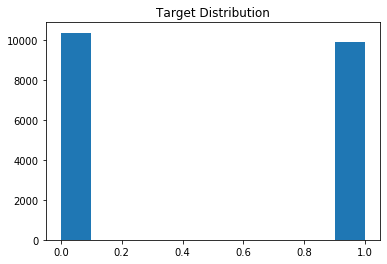

In [14]:
# Plot class distribution
plt.title("Target Distribution")
plt.hist(fake_news_df.label)
plt.show()

The distribution of the classes show that this is a balanced data set. Next, a feature will be created that extracts the word count of each article. Next will be to create some features from the characteristics of the text such as word count, word length, punctuation count, etc.

In [ ]:
# create a parcer object using SpaCy
nlp = spacy.load('en')
fake_news_df['nlp'] = fake_news_df.text.apply(lambda x: nlp(x))

In [12]:

# fake_news_df["adj_cnt"] = fake_news_df.nlp.apply(lambda x: len([word.pos_ for word in x if word.pos_ =='ADJ']))
# fake_news_df["verb_cnt"] = fake_news_df.nlp.apply(lambda x: len([word.pos_ for word in x if word.pos_ =='VERB']))
# fake_news_df["noun_cnt"] = fake_news_df.nlp.apply(lambda x: len([word.pos_ for word in x if word.pos_ =='NOUN']))
# fake_news_df["char_cnt"] = fake_news_df.text.apply(lambda x: len([letter for letter in x]))
# fake_news_df["punct_cnt"] = fake_news_df.nlp.apply(lambda x: len([word.text for word in x if word.is_punct]))
# fake_news_df["sent_cnt"] = fake_news_df.nlp.apply(lambda x: len([sent for sent in x.sents]))
# fake_news_df["avg_sent_length"] = fake_news_df.nlp.apply(lambda x: np.mean([len(sent) for sent in x.sents]))
# fake_news_df["avg_word_length"] = fake_news_df.nlp.apply(lambda x: np.mean([len(word.text) for word in x if not word.is_punct]))
# fake_news_df["word_cnt"] = fake_news_df.nlp.apply(lambda x: len([word.text for word in x if not word.is_punct]))
# fake_news_df['atricle_length'] = fake_news_df.text.apply(lambda x: len(x.split()))

Now we'll take a look at the ditributions of the new features we created.

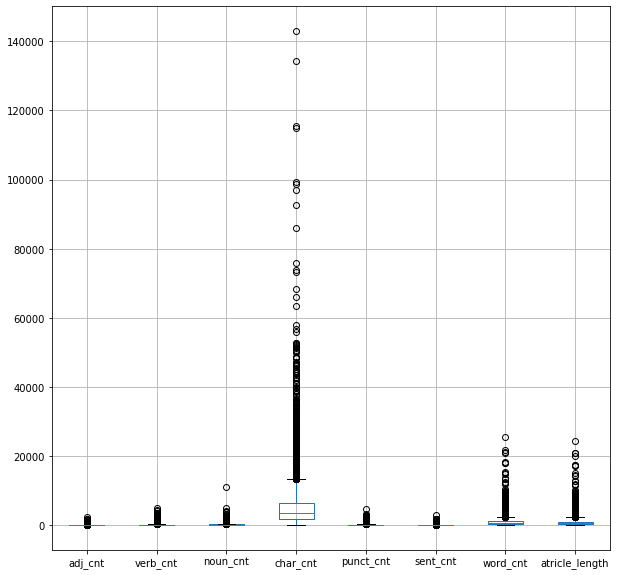

In [139]:
pd.DataFrame(fake_news_df.iloc[:,7:15]).boxplot(figsize=(10,10))
plt.show()

It seem that there are outliers in every feature. It is unlikely that these are all from typos and is more likely from the varation in the lengths of the entire aricles. Since this is the case we dont want to drop them. We won't do anything about them until the modeling phase since we may choose a model that is robust to outliers such as random forest. Let't now look at how each of the new features vary across the classes.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


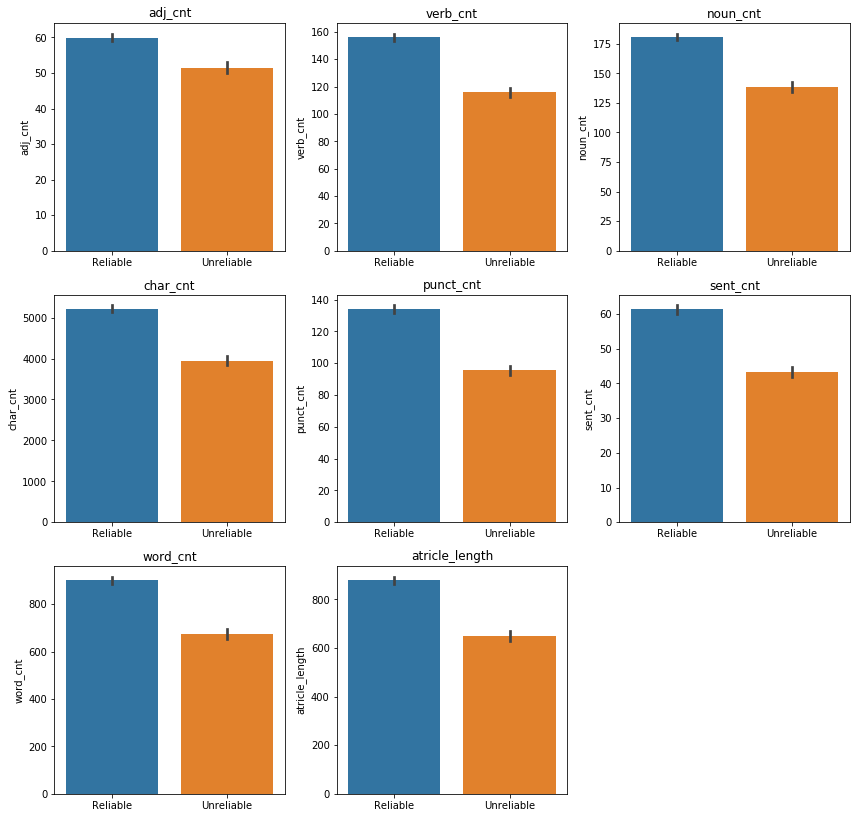

In [123]:
plt.figure(figsize=(12,15))
# plt.suptitle("Comparison of Count Variables and Classes")
 
for cols,   index in zip(fake_news_df.iloc[:,7:15].columns,range(len(fake_news_df.iloc[:,7:15].columns))):   

    plt.subplot(4,3,(index+1))
    
    sns.barplot (x='label',y=cols,data= fake_news_df )
    plt.xticks(labels=['Reliable','Unreliable'],ticks=[0,1])
    plt.xlabel("")
    plt.title(cols)
plt.tight_layout()
plt.show()

In [185]:
 for col in fake_news_df.iloc[:,7:15].columns:
    for i in range(len(fake_news_df.label.unique())):
            for j in range(i+1,2):
                print(col)
                print("Unreliable",' vs ',"Reliable") 
                print(stats.ttest_ind(
                      fake_news_df[fake_news_df.label==fake_news_df.label.unique()[i]][col], 
                      fake_news_df[fake_news_df.label==fake_news_df.label.unique()[j]][col]))
                 
                print()

adj_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-8.954578056419216, pvalue=3.6975272428202867e-19)

verb_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-17.949374702765255, pvalue=1.7306253996659513e-71)

noun_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-15.866109842404674, pvalue=2.3712837154124536e-56)

char_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-17.789603399012456, pvalue=2.902322391975288e-70)

punct_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-20.25487508359427, pvalue=2.506971047342987e-90)

sent_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-18.93363012678821, pvalue=2.9001683120677784e-79)

word_cnt
Unreliable  vs  Reliable
Ttest_indResult(statistic=-18.170819459640278, pvalue=3.3384923895026665e-73)

atricle_length
Unreliable  vs  Reliable
Ttest_indResult(statistic=-18.820639460592414, pvalue=2.373149402767342e-78)



Each feature shows significant differences between the means of the classes. This could be a good sign that the have some predictive power.


In [13]:
import pickle
file=open('textChars.pickle','rb')
txt_chr = pickle.load(file)
file.close()

In [426]:
# def text_ch(data):
    
#     df = pd.DataFrame()
#     df['nlp'] = [pd.Series(nlp(data))]
#     x= nlp(data)
#     df['text'] = data
#     df["adj_cnt"] =  len([word.pos_ for word in x if word.pos_ =='ADJ'])
#     df["verb_cnt"] =  len([word.pos_ for word in x if word.pos_ =='VERB'])
#     df["noun_cnt"] =  len([word.pos_ for word in x if word.pos_ =='NOUN'])
#     df["char_cnt"] =  len([letter for letter in str(x)])
#     df["punct_cnt"] =  len([word.text for word in x if word.is_punct])
#     df["sent_cnt"] =  len([sent for sent in x.sents])
#     df["word_cnt"] =   len([word.text for word in x if not word.is_punct])
#      return df;

In [15]:
fake_news_df.head()

,id,title,author,text,label,clean_text,processed_text,adj_cnt,verb_cnt,noun_cnt,char_cnt,punct_cnt,sent_cnt,word_cnt,atricle_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"(house, dem, aide, we, did, nt, even, see, com...",house aide comeys letter jason chaffetz tweete...,49,153,120,4930,94,46,855,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"(ever, get, the, feeling, your, life, circles,...",feeling life circles roundabout heads straight...,43,112,137,4160,113,49,717,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"(why, the, truth, might, get, you, fired, octo...",truth fired october tension intelligence analy...,109,211,251,7692,204,70,1285,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"(videos, civilians, killed, in, single, us, ai...",videos civilians killed single airstrike ident...,44,102,113,3237,59,28,574,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"(print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenced years prison ira...,6,30,41,938,23,9,156,154


In [5]:
# helper functions
nlp = spacy.load('en')

def clean_txt(words):    
    words = re.sub(r"[^a-zA-Z.' ]+", "", words)     
    words  = re.sub(r'\b\w{1}\b', '', words)       
    words = words.lower()
    words = " ".join(words.split())
    return nlp(words);

def process_text(words):  
    #words = nlp(words)
    words = [word.text for word in words                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and len(word)>3]
    return " ".join(words);


def pos_tagged(words):
    #words = nlp(words)
    word = [word.lemma_  for word in words                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and not word.lemma_ in stopwords
                         and len(word)>3] 
    words2 = [word.lemma_+"_"+word.pos_  for word in words                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and not word.lemma_ in stopwords
                         and len(word)>3] 
    return " ".join(word+words2);0

def lemmas(words):
    #words = nlp(words)
    words = [word.lemma_ for word in words                          
                         if  not word.is_punct 
                         and not word.text in stopwords
                         and len(word)>3] 
    return " ".join(words);

def vectors(vectorizer,data,tokenizer):
    
    if vectorizer == "tfidf":
        
        Vectorizer = TfidfVectorizer(analyzer='word',
                                 tokenizer = tokenizer,
                                 stop_words=stopwords,
                                 ngram_range=(1, 2),
                                 max_df=1.0,
                                 min_df=1,
                                 max_features=2000,
                                 use_idf=True, 
                                 smooth_idf=True)
        
        vecs = Vectorizer.fit_transform(data)
        
    elif vectorizer == "count":
        
        Vectorizer = CountVectorizer(lowercase=True, 
                              tokenizer = tokenizer,
                              stop_words=stopwords,
                              ngram_range=(1, 2),
                              analyzer='word',
                              max_df=1.0,
                              min_df=1,
                              max_features=2000)
        
        vecs = Vectorizer.fit_transform(data)           

    return Vectorizer, vecs;


def train_test_scores(model,train_data,test_data):    
    model.fit(data,y_train)
    train = model.score(train_data,y_train)
    test = model.score(test_data,y_test)
    return train, test;

def best_params(model, X_train , y_train, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='f1', return_train_score=True,verbose=1,n_jobs=-2)
    grid.fit(X_train , y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    return grid.best_params_;


In [6]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS

In [ ]:
fake_news_df['clean_text'] = fake_news_df.text.apply(clean_txt) # clean the text
# fake_news_df['processed_text'] = fake_news_df.clean_text.apply(process_text) # tokenize, remove stopwords, remove punct.

In [6]:
fake_news_df['processed_text'] = fake_news_df.clean_text.apply(process_text) # tokenize, remove stopwords, remove punct.

In [7]:
#check for text that has no values after processing
def empty_ind(data):
    ind = []
    for i in data.index:
        if(len(data[i].split()))==0:
            ind.append(i)
    return ind;
     

In [8]:
fake_news_df.drop(empty_ind(fake_news_df.processed_text),0,inplace=True)
fake_news_df.index = range(len(fake_news_df))

In [2]:
import pickle
file = open("fakeALL11-2.pickle","rb")
fake_news_df = pickle.load(file)
file.close()
# pickle out

Now that the data is clean we'll make some word clouds for each class and compare them.

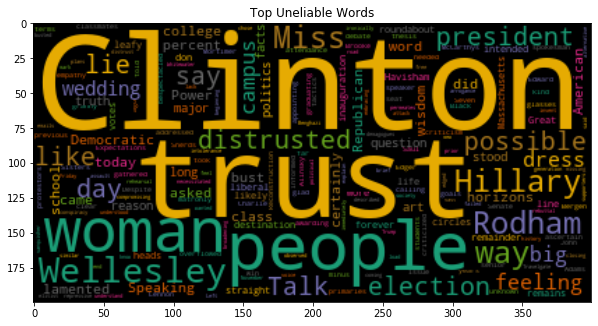

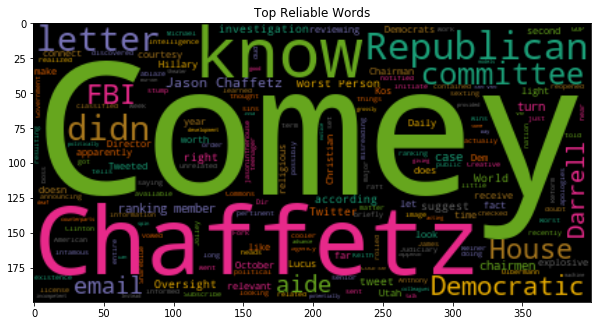

In [9]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(fake_news_df[fake_news_df.label==0].text.values[0].split()))
 

 
plt.imshow(wc, interpolation="bilinear")
plt.title("Top Uneliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(fake_news_df[fake_news_df.label==1].text.values[0].split()))
 
 

plt.imshow(wc, interpolation="bilinear")
plt.title("Top Reliable Words")
plt.show() 

It look like both classes have many similar words that are frequent between the two. This will be a problem since some of our modeling will use word frequencies as predictive features. If both classes have the same higher frequency words then the model will have a hard time distinguishing the two. After splitting the data into the train and test sets we'll create a bag of words and analyze the text to see what stopwords, if any, should be added to our stop word list.

In [10]:
# separate target
X = fake_news_df 
Y = fake_news_df.label

In [11]:
# # split into training validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=0)
  

In [12]:
print("Training data shape: ",X_train.shape)
print("Testing data shape: ",X_test.shape)

Training data shape:  (16260, 15)
Testing data shape:  (4065, 15)


## Bag of words features

We'll let sklean do the heavy lifting to create a bag of words matrix which we will modify into a document-term matrix

In [13]:
BOW_text, bow_xtrain = vectors("count",X_train.processed_text,None) 

In [14]:
doc_term_matrix = pd.DataFrame(bow_xtrain.toarray(), columns=BOW_text.get_feature_names())
doc_term_matrix['target_label'] = y_train.values
doc_term_matrix

,abedin,ability,able,abortion,abroad,absolutely,abuse,accept,access,according,...,york,york city,york times,young,younger,youtube,zero,zika,zone,target_label
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16256,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
16257,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16258,0,0,1,0,0,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0


Next well create a plot just to get an idea of how separated our classes are before we do any manipulation of the data. 

Text(0.5, 1.0, 'Bag of Words')

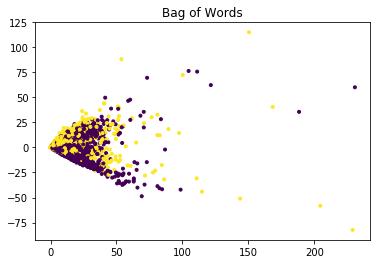

In [15]:
svd= TruncatedSVD(2) 
bow_svd = svd.fit_transform(bow_xtrain.toarray())
plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train,marker=".")
plt.title("Bag of Words")

In [16]:
# create document-term matrix
doc_term_matrix = pd.DataFrame(bow_xtrain.toarray(), columns=BOW_text.get_feature_names())
doc_term_matrix['target_labels'] = y_train.values

Next we will transpose the matrix. Then we will group the documents by class and sum across rows to get total counts per word in each class.

In [17]:
# sum the terms counts across 
grouped_term_sum = doc_term_matrix.groupby("target_labels").sum(axis=1).T # sum over the column axis to get score totals for each class
grouped_term_sum

target_labels,0,1
abedin,116,583
ability,751,572
able,1613,1407
abortion,547,212
abroad,349,245
...,...,...
younger,491,119
youtube,225,512
zero,239,410
zika,374,317


Here we create a dictionary and store the top 300 most fequent words per class. 

In [18]:
# declare a dictionary object and 
top_words_dict = {}
for label in grouped_term_sum.columns:
    top_words = grouped_term_sum[label].sort_values(ascending=False)[:300]
    top_words_dict[label] = list(zip(top_words.index,top_words.values))

Next we'll check to see if any if those words are in both classes. If the are we will add them to our stop word list.

In [19]:
top_reliable = []
top_unreliable = []

for label, words in top_words_dict.items():
    if label==0:
        print("Top Reliable words: \n")
        top_reliable.append(", ".join([word for (word, count) in words]))
        print(", ".join(top_reliable))
        print()
        print()
    if label==1:
        print("Top Unreliable words: \n")
        top_unreliable.append(", ".join([word for (word, count) in words]))
        print(", ".join(top_unreliable))     

Top Reliable words: 

said, trump, people, like, president, years, time, states, just, state, united, year, news, american, house, trumps, united states, government, going, white, percent, make, campaign, think, told, clinton, officials, national, police, york, obama, work, including, times, world, political, country, according, know, want, public, twitter, called, city, does, million, week, republican, long, media, security, administration, federal, group, party, donald, company, good, home, women, right, court, election, office, life, washington, family, later, health, department, added, days, school, asked, help, case, used, took, white house, come, members, left, support, university, policy, wrote, statement, really, little, need, chief, came, recent, team, business, executive, black, donald trump, night, republicans, children, breitbart, saying, general, money, care, place, military, things, change, months, director, north, friday, democrats, reported, power, great, interview, rep

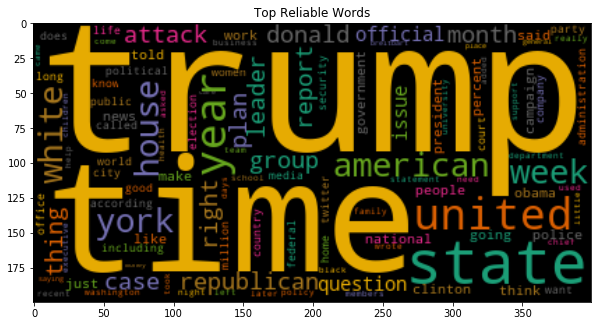

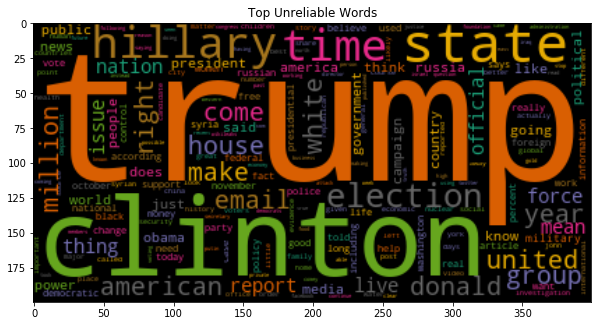

In [20]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(top_reliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(top_unreliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Unreliable Words")
plt.show() 

In [21]:
tops = []
for label in grouped_term_sum.columns:
    words = grouped_term_sum[label].sort_values(ascending=False)[:300].index
    for w in words:
        tops.append(w)

In [22]:
new_stop_words = []
common_words = dict(Counter(tops).most_common())
for stop, count in common_words.items():
    if count>1:
        new_stop_words.append(stop)


I would like to take the time to mention that the idea here was borrowed from Alice Zhao and can be found here. https://github.com/adashofdata/nlp-in-python-tutorial. Some of the code I wrote is very similar and modified. 

Next, the stop word list will be updated to include words that are in the top frequencies of both classes since the will not provide any predictive power between the them. Then well make some more word clouds so we can visualize the data and see if it makes sense.

In [20]:
# update stopwords
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS.union(new_stop_words+["com","say"])

In [21]:
import pickle 
# pickle out
pickle_out = open("STOPWORDS.pickle","wb")
pickle.dump(stopwords,pickle_out)
pickle_out.close()

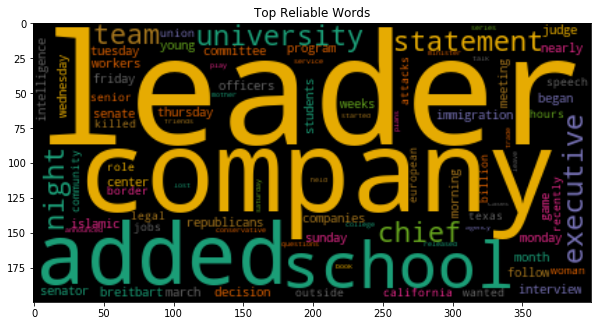

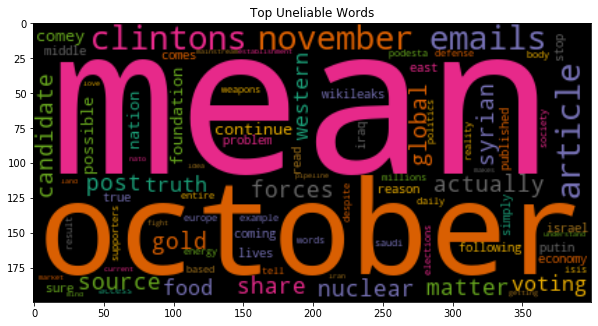

In [22]:
 
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.figure(figsize=(10,10))
wc.generate(" ".join(top_reliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Reliable Words")
plt.show() 
plt.figure(figsize=(10,10))
wc.generate(" ".join(top_unreliable))
plt.imshow(wc, interpolation="bilinear",)
plt.title("Top Uneliable Words")
plt.show() 

Now we need to reprocess the data to include the stop words. We'll will also create documents that are tokenized with lemmas and another set that is tokenized with lemmas plus those lemmas tagged with their parts of speech. The will help to create more sparse term document matrices and help the algorithms we use to separate the classes. The next blocs of code do this. Also, after processing some of the document end up blank so those rows will be removed.

In [23]:
fake_news_df['processed_text'] = fake_news_df.clean_text.apply(process_text)
fake_news_df['lemma_pos'] = fake_news_df.clean_text.apply(pos_tagged)
fake_news_df['lemmas'] = fake_news_df.clean_text.apply(lemmas)

In [24]:
X_train = fake_news_df.loc[X_train.index] 
X_test = fake_news_df.loc[X_test.index]

In [25]:
#check for text that has no values after processing and clean up
X_train.drop(empty_ind(X_train.processed_text),0,inplace=True)
X_train.drop(empty_ind(X_train.lemma_pos),0,inplace=True)
X_train.drop(empty_ind(X_train.lemmas),0,inplace=True) 
y_train = fake_news_df.label[X_train.index]

In [26]:
X_test.drop(empty_ind(X_test.processed_text),0,inplace=True)
X_test.drop(empty_ind(X_test.lemma_pos),0,inplace=True)
X_test.drop(empty_ind(X_test.lemmas),0,inplace=True)
y_test = fake_news_df.label[X_test.index]

In [27]:
# doc-term matrix without lemmas
BOW_text, bow_xtrain_text = vectors("count",X_train.processed_text,None)
bow_xtest_text = BOW_text.transform(X_test.processed_text)

In [28]:
# doc-term matrix with pos_tagged lemmas
BOW_lemmas_pos, bow_xtrain_lemmas_pos = vectors("count",X_train.lemma_pos,None)
bow_xtest_lemmas_pos = BOW_text.transform(X_test.lemma_pos)

In [29]:
# doc-term matrix with lemmas
BOW_lemmas, bow_xtrain_lemmas = vectors("count",X_train.lemmas,None)
bow_xtest_lemmas = BOW_text.transform(X_test.lemmas)

Now we will make more plots of the different matricies we created

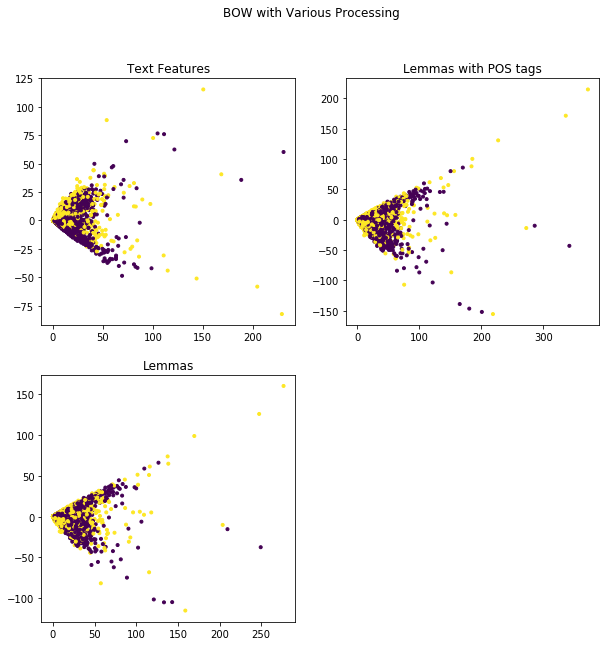

In [30]:
plt.figure(figsize=(10,10))
plt.suptitle("BOW with Various Processing")
models = [bow_xtrain_text,bow_xtrain_lemmas_pos,bow_xtrain_lemmas]
titles = ["Text Features","Lemmas with POS tags","Lemmas"]

svd = TruncatedSVD(2,random_state=0)

for features, title, index in zip(models,titles,range(3)):   

    plt.subplot(2,2,(index+1))
    bow_svd = svd.fit_transform(features.toarray())
    plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train,marker=".")
    plt.title(title)

plt.show()

Just by looking it doesn't really seem as though the data is any more separated than it was. We'll run a default random forrest classifer on the data and see how it it doing. Also, we can look at the feature importances to see which words are helping separate the classes and if any of those words are noise words that need to be cleaned up.

In [31]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(bow_xtrain_text.toarray(),y_train)
cv = cross_val_score(rfc, bow_xtrain_text.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.9065961220642457  +- 0.004004862216014893


Not to bad!! Let's take a look at the feaure importances

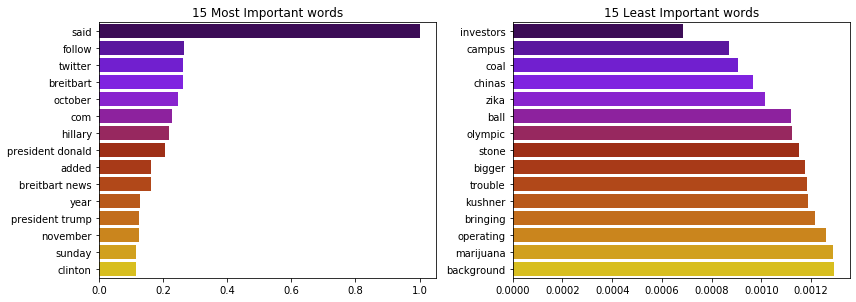

In [32]:
indices = rfc.feature_importances_.argsort()[::-1]
feature_importance = rfc.feature_importances_/rfc.feature_importances_.max()

plt.figure(figsize=(12,8))
plt.subplot(221)
sns.barplot(x=feature_importance[indices][:15],y = [BOW_text.get_feature_names()[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Most Important words")
plt.subplot(222)
indices = rfc.feature_importances_.argsort() 
sns.barplot(x=feature_importance[indices][:15],y = [BOW_text.get_feature_names()[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Least Important words")
plt.tight_layout()
plt.show() 

In [33]:
rfc.fit(bow_xtrain_lemmas.toarray(),y_train)
cv = cross_val_score(rfc, bow_xtrain_lemmas.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.9040240407639638  +- 0.005230477456388104


In [34]:
rfc.fit(bow_xtrain_lemmas_pos.toarray(),y_train)
cv = cross_val_score(rfc, bow_xtrain_lemmas_pos.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.8987111946547669  +- 0.003915317060823705


## Tfidf features

<img src="img131.gif">

Next we'll see if the model can be improved by adding tfidf wieghts to the bag of words matrix

In [35]:
TFIDF_vec, X_train_tfidf_text = vectors("tfidf",X_train.processed_text,None)
X_test_tfidf_text = TFIDF_vec.transform(X_test.processed_text) 

In [36]:
TFIDF_vec_pos, X_train_tfidf_pos = vectors("tfidf",X_train.lemma_pos ,None)
X_test_tfidf_pos = TFIDF_vec_pos.transform(X_test.lemma_pos) 

In [37]:
TFIDF_vec_lemmas ,X_train_tfidf_lemmas = vectors("tfidf",X_train.lemmas,None)
X_test_tfidf_lemmas = TFIDF_vec_lemmas.transform(X_test.lemmas) 

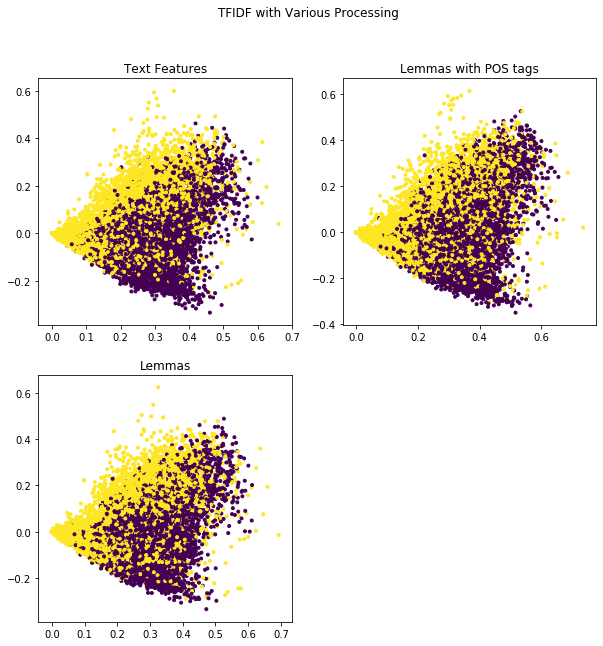

In [38]:
plt.figure(figsize=(10,10))
plt.suptitle("TFIDF with Various Processing")
models = [X_train_tfidf_text,X_train_tfidf_pos,X_train_tfidf_lemmas]
titles = ["Text Features","Lemmas with POS tags","Lemmas"]
svd = TruncatedSVD(2)

for features, title, index in zip(models,titles,range(3)):   

    plt.subplot(2,2,(index+1))
    bow_svd = normalize(features.toarray())
    bow_svd = svd.fit_transform(bow_svd)
     
    plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train,marker=".")
    plt.title(title)

plt.show()

In [39]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_tfidf_text.toarray(),y_train)
cv = cross_val_score(rfc, X_train_tfidf_text.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.9083490832637584  +- 0.003160685812498302


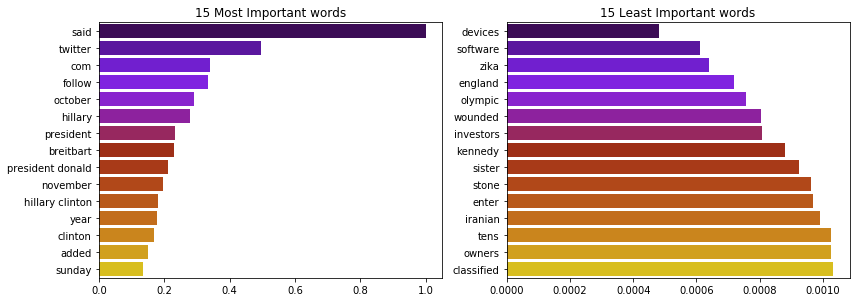

In [40]:
indices = rfc.feature_importances_.argsort()[::-1] 
feature_importance = rfc.feature_importances_/rfc.feature_importances_.max()

plt.figure(figsize=(12,8))
plt.subplot(221)
sns.barplot(x=feature_importance[indices][:15],y = [BOW_text.get_feature_names()[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Most Important words")
plt.subplot(222)
indices = rfc.feature_importances_.argsort() 
sns.barplot(x=feature_importance[indices][:15],y = [BOW_text.get_feature_names()[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Least Important words")
plt.tight_layout()
plt.show()
 

In [41]:
rfc.fit(X_train_tfidf_lemmas.toarray(),y_train)
cv = cross_val_score(rfc, X_train_tfidf_lemmas.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.9059389456732326  +- 0.004466152752395172


In [42]:
rfc.fit(X_train_tfidf_pos.toarray(),y_train)
cv = cross_val_score(rfc, X_train_tfidf_pos.toarray(),y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.9033943676811661  +- 0.003249517247932761


## Latent Samantic Analysis on tfidf
It is possible that reliable and unreliable documents share similar will be more similar to each other in their respective categories. We can use LSA on a tfidf matrix and then multipy that matix my its transpose so that each document vector is being mulitplied by every other vecotor in the set. Since the matirix is normalized this will produce an approximate cosine similarity matrix where we can test the hypothesis. 

In [43]:
svd= TruncatedSVD(30)
lsa = make_pipeline(svd, Normalizer(copy=False))
 
X_train_lsa_text = lsa.fit_transform(X_train_tfidf_text)
X_test_lsa_text = lsa.transform(X_test_tfidf_text)

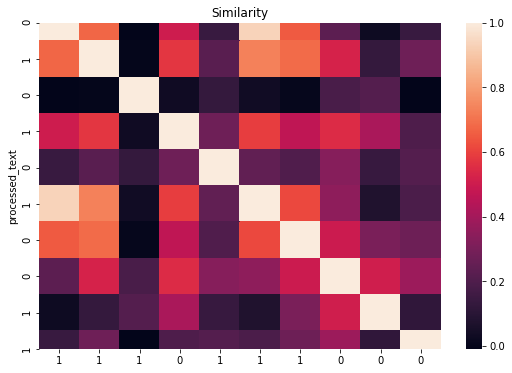

In [44]:
# Compute document similarity  
similarity = np.asarray(np.asmatrix(X_train_lsa_text) * np.asmatrix(X_train_lsa_text).T)
sim_matrix=pd.DataFrame(similarity,index=X_train.processed_text).iloc[500:510,500:510]
plt.figure(figsize=(9,6))
ax = sns.heatmap(sim_matrix,xticklabels=y_train[500:510],yticklabels=y_train[:10])
plt.title('Similarity')
plt.show()

In [45]:
# add labels to similarity df to separate the classes
sim_df = pd.DataFrame(similarity)
sim_df['labels'] = y_train.values

In [46]:
# average the unreliable columns
average_sim = sim_df[sim_df.labels==1].drop('labels',1).mean(axis=0).values 

In [47]:
X_train['average_sim'] = average_sim

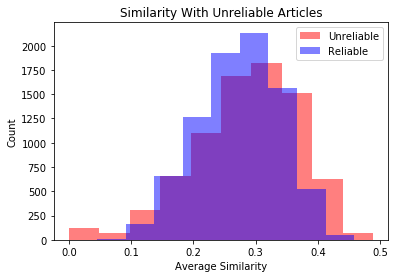

In [48]:
plt.hist(X_train[X_train.label==1].average_sim,alpha=.5, color='red',label="Unreliable")
plt.hist(X_train[X_train.label==0].average_sim,alpha=.5,color='blue',label="Reliable")
plt.title("Similarity With Unreliable Articles")
plt.xlabel('Average Similarity')
plt.ylabel('Count')
plt.legend()
plt.show()

In [49]:
from scipy import stats
stats.ttest_ind(X_train[X_train.label==1].average_sim, X_train[X_train.label==0].average_sim)

Ttest_indResult(statistic=9.658318984088163, pvalue=5.193434899533042e-22)

In [50]:
def sim_transform(data):    
    tr=pd.DataFrame(X_train_lsa_text)
    tr['l'] = y_train.values
    simtst =pd.concat([pd.DataFrame(data), tr[tr.l==1].drop('l',1)],axis=0)
    sim = cosine_similarity(np.asmatrix(simtst),np.asmatrix(simtst))      
    average_sim = sim.mean(axis=0)[:len(data)]     
    return average_sim;

X_test['average_sim'] = sim_transform(X_test_lsa_text)

From the histogram it would appear that on average unrealiable news articles have a higher similarity scores among each other than reliable news articles.

## Non-negative Matrix Factorization
Here we will create a feature by using NNMF to model topics and then use the probabilities that a document belongs to a certain topic to group the documents. That grouping will then be used as a predictive feature.

In [51]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar',  
          l1_ratio=0.0,  
          max_iter=200,  
          n_components=20, 
          random_state=0, 
          solver='cd',  
          tol=0.0001,  
          verbose=0  
         )

In [52]:
X_train_nnmf = pd.DataFrame(nmf.fit_transform(X_train_tfidf_text))  
X_test_nnmf = pd.DataFrame(nmf.transform(X_test_tfidf_text))  

In [53]:
term_topic_df = pd.DataFrame(nmf.components_, columns=TFIDF_vec.get_feature_names()).T
term_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
abedin,0.000000,0.000000,0.122659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ability,0.114894,0.000000,0.000000,0.012640,0.000000,0.032261,0.004996,0.008034,0.055169,0.002970,0.034139,0.000000,0.022003,0.009221,0.001148,0.001738,0.017197,0.013601,0.019714,0.000000
able,0.249245,0.000000,0.000000,0.030733,0.036017,0.040930,0.000000,0.000000,0.055547,0.016865,0.053279,0.007994,0.018084,0.013532,0.002569,0.041291,0.032975,0.011754,0.013274,0.012367
abortion,0.025930,0.010612,0.010018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115969,0.000000,0.034636,0.000000,0.000000,0.000000,0.000000,0.155482,0.000000,0.000000
abroad,0.014879,0.005747,0.000000,0.034300,0.003231,0.017450,0.000000,0.000000,0.024997,0.026256,0.000000,0.005101,0.007549,0.000000,0.000000,0.007095,0.000515,0.008201,0.046925,0.008418


Let's take a look at the topics and see if they make sense. This will give a generally idea if the algorithim is working the way we expect.

In [54]:
for i in term_topic_df: 
    topic_words = [term_topic_df[i].sort_values(ascending=False)[:15].index][0]
    print("TOPIC {}:".format(i+1))
    print([i for i in topic_words])
    print()

TOPIC 1:
['like', 'people', 'just', 'time', 'life', 'know', 'world', 'think', 'things', 'make', 'good', 'want', 'does', 'really', 'going']

TOPIC 2:
['trump', 'donald', 'donald trump', 'trumps', 'president', 'trump said', 'campaign', 'republican', 'america', 'supporters', 'going', 'presidential', 'twitter', 'donald trumps', 'nominee']

TOPIC 3:
['clinton', 'hillary', 'hillary clinton', 'clintons', 'campaign', 'wikileaks', 'podesta', 'foundation', 'emails', 'clinton foundation', 'email', 'clinton campaign', 'hillarys', 'hillary clintons', 'democratic']

TOPIC 4:
['syria', 'islamic', 'syrian', 'mosul', 'forces', 'islamic state', 'military', 'isis', 'iraq', 'state', 'aleppo', 'government', 'iraqi', 'turkey', 'attack']

TOPIC 5:
['said', 'officials', 'added', 'city', 'told', 'family', 'years', 'interview', 'york', 'people', 'asked', 'like', 'friday', 'home', 'year']

TOPIC 6:
['election', 'vote', 'voters', 'party', 'voting', 'democrats', 'republican', 'democratic', 'votes', 'voter', 'elect

The topics seem to make sense. You can see for example that topic 8 is about sports and topic 20 is about education. A new feature will be made by returning the column index, which represents the topic number, from the columns with the highest value. This will be similar to clustering the documents.

In [55]:
# set topic feature
X_train.loc[:,'nmf_topics'] = X_train_nnmf.idxmax(axis=1).values
X_test.loc[:,'nmf_topics'] = X_test_nnmf.idxmax(axis=1).values

## Word2Vec features

In order to produce the word embeddings from word2vec the data has to be tokenized into sentences. In this case, since we are classifying documents and not sentences, each document will be treated like one long sentence.

In [83]:
from gensim.models import word2vec

In [84]:
W2Vmodel = gensim.models.KeyedVectors.load_word2vec_format ('GoogleNews-vectors-negative300.bin', binary=True)

In [85]:
# function that returns a data frame of averaged word vectors(document vectors)
def mean_word_vecs(data,model):     
    vecs = {}
    for index in data.index:
        
        words = [word for word in data[index].split() 
                 if word in model.vocab]
        
        if len(words)>0:
            vecs[index] = model[words].mean(axis=0) 
        else:
            vecs[index] = 0
    return pd.DataFrame(vecs).T 
    return df;

In [73]:
W2Vtrain = mean_word_vecs(X_train.processed_text,W2Vmodel)
W2Vtest = mean_word_vecs(X_test.processed_text,W2Vmodel)

In [86]:
# pickle_out = open("W2Vtrain11-2.pickle","wb")
# pickle.dump(W2Vtrain,pickle_out)
# pickle_out.close()
# pickle_out = open("W2Vtest11-2.pickle","wb")
# pickle.dump(W2Vtest,pickle_out)
# pickle_out.close() 


file = open("W2Vtrain11-2.pickle","rb")
W2Vtrain = pickle.load(file)
pickle_out.close()
file = open("W2Vtest11-2.pickle","rb")
W2Vtest = pickle.load(file)
pickle_out.close() 

In [106]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(W2Vtrain,y_train)
cv = cross_val_score(rfc,W2Vtrain,y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.7962399844658442  +- 0.008261887857366288


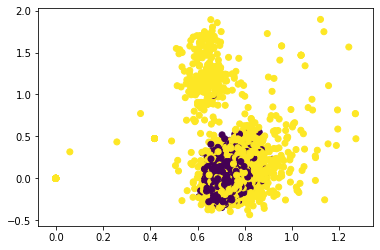

In [88]:
svd = TruncatedSVD(2)

svd = svd.fit_transform(W2Vtrain)
plt.scatter(svd[:,0],svd[:,1],c=y_train)
plt.title("")
plt.show()
 

Here the Word2Vec model will be trained on the news corpus.

In [89]:
# convert data into input that W2V likes.
def W2Vsentences(data):
    sentences = []
    for txt in data:
        words1 = [word.lemma_  for word in txt                              
                             if  not word.is_punct
                             and not word.text in stopwords
                             and len(word)>3] 

        words2 = [word.lemma_+"_"+word.pos_  for word in txt  
                             if  not word.is_punct 
                             and not word.text in stopwords
                             and len(word)>3] 
        sentences.append(words1+words2)
    return sentences;


In [90]:
pos_tagged_sents = W2Vsentences(fake_news_df.clean_text)  

In [91]:
# Word2Vec trained on pos tagged sentences
news2vec = word2vec.Word2Vec(
    pos_tagged_sents,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)
print('done!')

done!


In [92]:
news2vec_train = mean_word_vecs(X_train.processed_text,news2vec.wv)
news2vec_test = mean_word_vecs(X_test.processed_text,news2vec.wv)

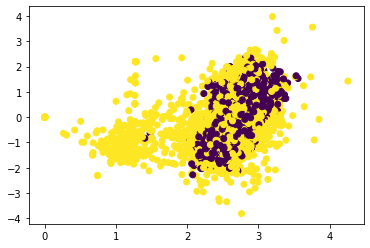

In [93]:
svd = TruncatedSVD(2)
bow_svd = svd.fit_transform(news2vec_train)
plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train)
plt.title("")
plt.show()

In [94]:
news2vec.wv.save_word2vec_format('TrainedW2V.bin', binary=True)
news2vec = gensim.models.KeyedVectors.load_word2vec_format('TrainedW2V.bin',binary=True)  

In [107]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(news2vec_train,y_train)
cv = cross_val_score(rfc,news2vec_train,y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.8480824753165767  +- 0.004750219809273531


## Doc2Vec features


In [200]:
tagged_docs = [TaggedDocument(words=str(nlp(doc)).split() , tags=[str(i)]) for i, doc in enumerate(X_train.lemma_pos.values)]

In [108]:
# pickle_out = open("tagged_docs.pickle","wb")
# pickle.dump(tagged_docs,pickle_out)
# pickle_out.close()

file = open("tagged_docs.pickle","rb")
tagged_docs = pickle.load(file)
file.close()

In [109]:
D2V = Doc2Vec(vector_size=300,
                alpha=.025, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
D2V.build_vocab(tagged_docs)

In [110]:
def get_doc_vecs(data):
    vecs = {}
    for index in data.index:
        words = [word for word in data[index].split() if not word in stopwords]

        vecs[index] = D2V.infer_vector(words)
    return pd.DataFrame(vecs).T 

In [111]:
X_trainD2V = get_doc_vecs(X_train.processed_text)
X_testD2V = get_doc_vecs(X_test.processed_text)

In [112]:
X_trainD2V.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
13588,-0.000978,-0.001332,0.000169,0.000289,0.000552,0.001176,0.000589,0.000083,0.001405,-0.000064,...,-0.000968,-0.000783,0.000993,0.000951,-0.000780,-0.001485,0.000691,0.000688,0.000294,-0.000886
15663,-0.001406,-0.000533,0.001354,-0.000457,-0.000773,0.001434,-0.001040,0.000093,-0.001098,0.000186,...,-0.001457,0.000612,-0.001305,-0.000337,0.000622,-0.000851,0.001198,0.001378,-0.001579,0.000350
15866,-0.000905,0.001350,-0.000657,-0.001485,0.000599,0.001262,-0.000116,-0.000468,-0.001332,-0.001413,...,0.000762,-0.000844,0.001648,0.000420,0.000672,-0.001244,-0.000303,0.000339,-0.000210,0.001069
1585,0.000390,0.000729,0.001598,0.000521,-0.000614,0.001203,0.000771,-0.001658,0.000046,0.000604,...,-0.001613,0.000344,0.000652,-0.000196,0.001118,-0.001065,0.000095,0.000545,-0.001585,0.000330
9442,0.001070,0.000321,-0.000288,0.001551,-0.001331,-0.001202,-0.000914,-0.001346,0.000183,0.001398,...,-0.001470,-0.000735,0.001545,-0.000951,0.001526,0.000650,0.000607,0.000476,0.001372,-0.000289


In [113]:
X_trainD2V.shape

(16250, 300)

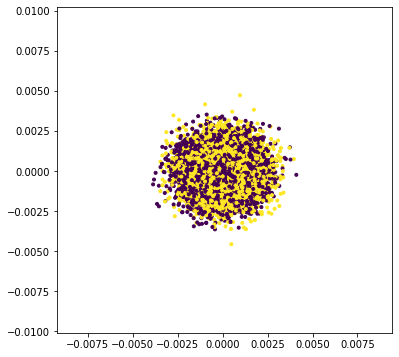

In [114]:
plt.figure(figsize=(6,6))
svd = TruncatedSVD(2)

bow_svd = svd.fit_transform(X_trainD2V)
plt.scatter(bow_svd[:,0],bow_svd[:,1],c=y_train, marker=".")
plt.show()

In [115]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_trainD2V,y_train)
cv = cross_val_score(rfc,X_trainD2V,y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))


0.44559351623161536  +- 0.0064745183782376


In [89]:
107+2010


2117

In [88]:
bow_train_chars.shape

(16250, 2010)

## Feature Selection

From the initial scores above for the document term matricies it looks like the bag of word model is showing the best promise. show wel will continue from here to model with those features and a combinations of the count features we created in the beginning. Speaking of those let's see how they score initially on their own plus the similarity and topic featues we created.  

In [56]:
X_train_chars = X_train[['adj_cnt', 'verb_cnt', 'noun_cnt', 'char_cnt',
                         'punct_cnt', 'sent_cnt', 'word_cnt', 'atricle_length','average_sim', 'nmf_topics']]
X_test_chars = X_test[['adj_cnt', 'verb_cnt', 'noun_cnt', 'char_cnt',
                         'punct_cnt', 'sent_cnt', 'word_cnt', 'atricle_length','average_sim', 'nmf_topics']]

In [57]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_chars,y_train)
cv = cross_val_score(rfc, X_train_chars,y_train,cv=3,scoring='f1')
print(cv.mean()," +- {}".format(cv.std()))

0.7738102617433186  +- 0.005862266289697297


In [58]:
bow text  0.892613398722561  +- 0.002641733750289381
bow lemmas 0.8814096382145252  +- 0.0030415145022896243
bow lemmas with pos 0.8795385808212975  +- 0.0026592861413408824
tfidf text 0.8805728137973495  +- 0.007191629800695493
tfidf lemmas 0.8805728137973495  +- 0.007191629800695493
tfidf lemmas with pos 0.8805728137973495  +- 0.007191629800695493
W2V Google 0.7962399844658442  +- 0.008261887857366288
W2V corpus 0.8480824753165767  +- 0.004750219809273531
Doc2Vec corpus 0.44559351623161536  +- 0.0064745183782376

text char features 0.7730792792221189  +- 0.002297652047582764

SyntaxError: invalid syntax (<ipython-input-58-6fae7ba52d1a>, line 1)

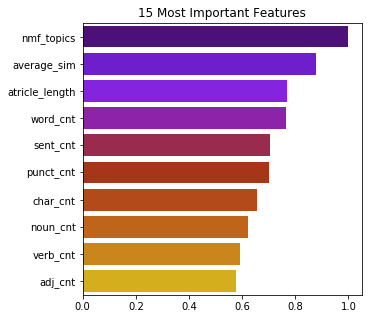

In [62]:
indices = rfc.feature_importances_.argsort() 
feature_importance = rfc.feature_importances_/rfc.feature_importances_.max()

plt.figure(figsize=(5,5))
 
sns.barplot(x=feature_importance[indices[::-1]][:15],y = X_train_chars.columns[::-1][:15],palette="gnuplot")
plt.title("15 Most Important Features")
plt.show()  
 

It looks like the similarity and topics features turned out to be pretty go predictors

In [58]:
bnb = BernoulliNB()
mnb = MultinomialNB(fit_prior=False)
lr  = LogisticRegression( solver='liblinear',class_weight='balanced')
rfc = ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=100,class_weight='balanced',random_state=20)
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,loss='deviance')
lasso = LogisticRegression(penalty='l1',solver='liblinear',max_iter=50,C=.01, warm_start=True)
svm = SVC(kernel = 'rbf')

Here we will concatenate the BOW vectors with the text characteristics features. This way the model will not only learn content of the articles but how they are written. This will help later when we want to generlize on new articles with topics that may not be in the training set. 

In [85]:
#  tfidf_train_chars = pd.concat([pd.DataFrame(X_train_tfidf_text.toarray(),
#                      index=X_train.index,columns=TFIDF_vec.get_feature_names()),X_train_chars],axis=1)
#  tfidf_test_chars = pd.concat([pd.DataFrame(X_test_tfidf_text.toarray(),
#                    index=X_test.index,columns=TFIDF_vec.get_feature_names()),X_test_chars],axis=1)
bow_train_chars =pd.concat([pd.DataFrame(bow_xtrain_text.toarray(),
                            index=X_train.index,columns=BOW_text.get_feature_names()),X_train_chars],axis=1)
bow_test_chars =pd.concat([pd.DataFrame(bow_xtest_text.toarray(),
                            index=X_test.index,columns = BOW_text.get_feature_names()),X_test_chars],axis=1)

,adj_cnt,verb_cnt,noun_cnt,char_cnt,punct_cnt,sent_cnt,word_cnt,atricle_length,average_sim,nmf_topics
13588,94,251,268,8104,194,95,1386,1317,0.330061,6
15663,38,94,119,3868,122,44,634,626,0.314254,10
15866,143,195,273,7706,161,66,1252,1223,0.271601,7
1585,21,28,69,4701,34,35,338,345,0.387290,2
9442,29,71,107,2606,53,26,447,437,0.210337,14
...,...,...,...,...,...,...,...,...,...,...
13123,8,34,32,1155,21,11,196,187,0.310577,1
19648,75,148,199,4965,115,53,826,796,0.341057,8
9845,71,170,159,6112,160,77,1086,1050,0.213217,16
10799,92,218,306,7908,185,82,1385,1342,0.281691,8


In [60]:
# find correlations to target
corr_matrix = pd.concat([bow_train_chars,y_train],axis=1).corr().abs()
corr_to_target = corr_matrix['label'].sort_values(ascending=False)

In [61]:
corr_to_target[:15]

label               1.000000
said                0.441044
added               0.216491
president donald    0.211281
hillary             0.204849
week                0.192361
october             0.190171
year                0.186007
breitbart           0.184003
follow              0.182425
including           0.175211
trumps              0.174947
york                0.174199
twitter             0.173248
executive           0.172482
Name: label, dtype: float64

In [62]:
corr_matrix

,abedin,ability,able,abortion,abroad,absolutely,abuse,accept,access,according,...,verb_cnt,noun_cnt,char_cnt,punct_cnt,sent_cnt,word_cnt,atricle_length,average_sim,nmf_topics,label
abedin,1.000000,0.009235,0.012582,0.006198,0.009452,0.000533,0.000948,0.014230,0.039576,0.053565,...,0.021575,0.018331,0.027072,0.016854,0.016204,0.025016,0.024690,0.002085,0.004915,0.064878
ability,0.009235,1.000000,0.180746,0.018788,0.052726,0.062130,0.025284,0.046622,0.063996,0.060841,...,0.237756,0.217562,0.238271,0.208074,0.184834,0.236588,0.237530,0.084737,0.004968,0.026808
able,0.012582,0.180746,1.000000,0.009261,0.086816,0.159900,0.050829,0.107009,0.089533,0.086667,...,0.458121,0.375002,0.418755,0.392076,0.392914,0.431581,0.430230,0.124320,0.013429,0.015652
abortion,0.006198,0.018788,0.009261,1.000000,0.038839,0.026571,0.002276,0.010386,0.056948,0.011382,...,0.046312,0.043697,0.047918,0.050116,0.042908,0.046430,0.046004,0.008681,0.012079,0.031566
abroad,0.009452,0.052726,0.086816,0.038839,1.000000,0.042918,0.009378,0.027003,0.026969,0.064936,...,0.195860,0.172225,0.196114,0.173703,0.164565,0.196669,0.197044,0.053647,0.015855,0.022587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
word_cnt,0.025016,0.236588,0.431581,0.046430,0.196669,0.284509,0.117395,0.215550,0.185373,0.297366,...,0.980667,0.944114,0.997267,0.963653,0.930814,1.000000,0.999789,0.254408,0.018599,0.121154
atricle_length,0.024690,0.237530,0.430230,0.046004,0.197044,0.281770,0.117635,0.215862,0.185934,0.298504,...,0.979678,0.945592,0.997666,0.964051,0.930087,0.999789,1.000000,0.253561,0.017642,0.125378
average_sim,0.002085,0.084737,0.124320,0.008681,0.053647,0.102349,0.036512,0.090718,0.008016,0.027797,...,0.267762,0.202575,0.247282,0.256492,0.223112,0.254408,0.253561,1.000000,0.296599,0.075531
nmf_topics,0.004915,0.004968,0.013429,0.012079,0.015855,0.031134,0.028563,0.029374,0.064909,0.047987,...,0.032841,0.001700,0.011044,0.035220,0.041912,0.018599,0.017642,0.296599,1.000000,0.154810


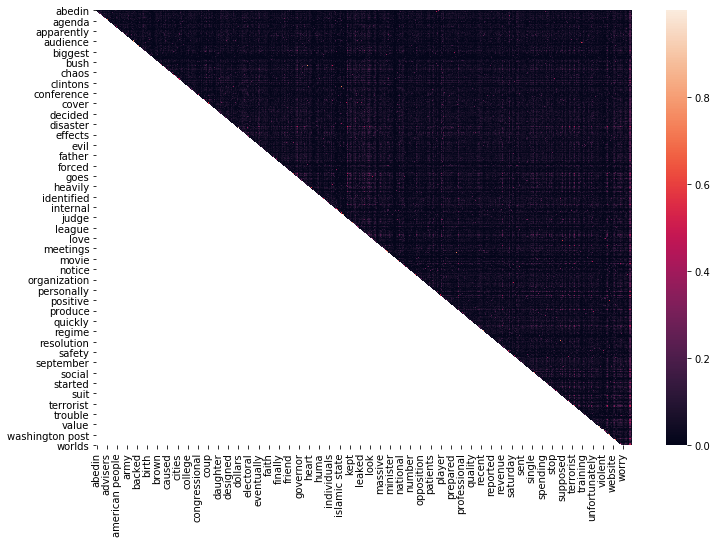

In [63]:
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [64]:
[column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]

['african',
 'attorney general',
 'banks',
 'barack obama',
 'bernie sanders',
 'breitbart news',
 'british',
 'care',
 'chief executive',
 'chinas',
 'chinese',
 'christians',
 'citys',
 'civil rights',
 'civilians',
 'climate',
 'climate change',
 'clinton campaign',
 'clintons',
 'companys',
 'core',
 'country',
 'courts',
 'dakota',
 'debt',
 'democratic party',
 'democrats',
 'dollar',
 'dollars',
 'donald trump',
 'drugs',
 'economy',
 'emails',
 'european',
 'european union',
 'executive',
 'executive order',
 'fake news',
 'federal government',
 'follow twitter',
 'foreign policy',
 'foundation',
 'french',
 'games',
 'george bush',
 'germany',
 'going',
 'good',
 'health',
 'health care',
 'heres',
 'high school',
 'hillary',
 'hillary clinton',
 'hillary clintons',
 'huma',
 'human rights',
 'immigration',
 'insurance',
 'iranian',
 'islamic state',
 'israeli',
 'james comey',
 'jerusalem',
 'jewish',
 'jews',
 'just',
 'justice department',
 'know',
 'korean',
 'like',
 'liv

In [65]:
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))
to_drop

Columns to drop:  194


['african',
 'attorney general',
 'banks',
 'barack obama',
 'bernie sanders',
 'breitbart news',
 'british',
 'care',
 'chief executive',
 'chinas',
 'chinese',
 'christians',
 'citys',
 'civil rights',
 'civilians',
 'climate',
 'climate change',
 'clinton campaign',
 'clintons',
 'companys',
 'core',
 'country',
 'courts',
 'dakota',
 'debt',
 'democratic party',
 'democrats',
 'dollar',
 'dollars',
 'donald trump',
 'drugs',
 'economy',
 'emails',
 'european',
 'european union',
 'executive',
 'executive order',
 'fake news',
 'federal government',
 'follow twitter',
 'foreign policy',
 'foundation',
 'french',
 'games',
 'george bush',
 'germany',
 'going',
 'good',
 'health',
 'health care',
 'heres',
 'high school',
 'hillary',
 'hillary clinton',
 'hillary clintons',
 'huma',
 'human rights',
 'immigration',
 'insurance',
 'iranian',
 'islamic state',
 'israeli',
 'james comey',
 'jerusalem',
 'jewish',
 'jews',
 'just',
 'justice department',
 'know',
 'korean',
 'like',
 'liv

After selecting it seems that most of the text characteristics correlated highly with each other. They will be removed. 

In [77]:
bow_train_chars_selected = bow_train_chars.drop(to_drop,1)
bow_test_chars_selected = bow_test_chars.drop(to_drop,1)

In [82]:
[i for i in X_train_chars.columns if i in bow_train_chars_selected.columns]

['average_sim', 'nmf_topics']

# Modeling

Now that we have our features selected let's train the models we will most likely use for production. The metric we want to use is the F1 score which is the harmonic mean of precision and recall. The reasoning behind this is that classifying an article as unreliable when it is can have the same negative implications of mis-classifying and unreliable article. 

In [72]:
#instatiate the moels to be used
lr  = LogisticRegression( solver='liblinear',class_weight='balanced') # because it is a simple model with interpretibility
rfc = ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=100,class_weight='balanced',random_state=20) # Robust to outliers
clf = ensemble.GradientBoostingClassifier(n_estimators=100,loss='deviance') # can help to control bias/variance if needed

In [98]:
#Logistic Regression
lr.fit(bow_train_chars,y_train)
cv = cross_val_score(lr, bow_train_chars,y_train,cv=3)
pred = cross_val_predict(lr,bow_train_chars,y_train,cv=3)
def report(cv,pred,target):
    print("Mean cross validation score: ",cv.mean()," +- {}".format(cv.std()))
    print("Confusion Matrix")
    print(pd.crosstab(target,pred))
    print()
    print("Classification Report")
    print(classification_report(target,pred))
report(cv ,pred,y_train)

Mean cross validation score:  0.9203567811765921  +- 0.0009010420203594187
Confusion Matrix
col_0     0     1
label            
0      7603   694
1       601  7362

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8297
           1       0.91      0.92      0.92      7963

    accuracy                           0.92     16260
   macro avg       0.92      0.92      0.92     16260
weighted avg       0.92      0.92      0.92     16260



In [109]:
a = lr.coef_.argsort()[0][::-1]

In [114]:
list(bow_train_chars.iloc[:,a].columns)

['october',
 'com',
 'november',
 'share',
 'print',
 'click',
 'source',
 'shares',
 'hillary',
 'earth',
 'articles',
 'jesus',
 'august',
 'express',
 'dream',
 'sources',
 'refused',
 'plus',
 'attorney',
 'related',
 'wins',
 'short',
 'comments',
 'plane',
 'noted',
 'completely',
 'massive',
 'earlier',
 'victory',
 'clearly',
 'ancient',
 'corrupt',
 'position',
 'email',
 'powerful',
 'foreign policy',
 'september',
 'forget',
 'complete',
 'actually',
 'decided',
 'defense',
 'class',
 'movement',
 'maintain',
 'soon',
 'soros',
 'listen',
 'positions',
 'realize',
 'clinton campaign',
 'door',
 'actions',
 'alternative',
 'disease',
 'elected',
 'millions',
 'simply',
 'representative',
 'chris',
 'believes',
 'comment',
 'breaking',
 'destruction',
 'committed',
 'isis',
 'personally',
 'confirmed',
 'radio',
 'agents',
 'operations',
 'jews',
 'previous',
 'image',
 'photo',
 'politicians',
 'link',
 'situation',
 'journalist',
 'vice',
 'relations',
 'average_sim',
 'free

In [100]:
#MultinomialNB
mnb.fit(bow_train_chars,y_train)
cv = cross_val_score(mnb, bow_train_chars,y_train,cv=3)
pred = cross_val_predict(mnb,bow_train_chars,y_train,cv=3)
report(cv ,pred,y_train)

Mean cross validation score:  0.8581177602748945  +- 0.002805883399959734
Confusion Matrix
col_0     0     1
label            
0      7418   879
1      1428  6535

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      8297
           1       0.88      0.82      0.85      7963

    accuracy                           0.86     16260
   macro avg       0.86      0.86      0.86     16260
weighted avg       0.86      0.86      0.86     16260



In [89]:
# Random forest 
rfc.fit(bow_train_chars_selected,y_train)
cv = cross_val_score(rfc, bow_train_chars,y_train,cv=3)
pred = cross_val_predict(rfc,bow_train_chars,y_train,cv=3)
report(cv ,pred,y_train)

Mean cross validation score:  0.9153132540767376  +- 0.002677721884960388
Confusion Matrix
col_0     0     1
label            
0      7721   576
1       801  7162

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      8297
           1       0.93      0.90      0.91      7963

    accuracy                           0.92     16260
   macro avg       0.92      0.91      0.92     16260
weighted avg       0.92      0.92      0.92     16260



In [252]:
# Gradient boost  
clf.fit(bow_train_chars_selected,y_train)
cv = cross_val_score(clf, bow_train_chars_selected,y_train,cv=3)
pred = cross_val_predict(clf,bow_train_chars_selected,y_train,cv=3)
report(cv ,pred,y_train)

Mean cross validation score:  0.885969010247023  +- 0.003938060993791572
Confusion Matrix
col_0     0     1
label            
0      7345   952
1       918  7035

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      8297
           1       0.88      0.88      0.88      7953

    accuracy                           0.88     16250
   macro avg       0.88      0.88      0.88     16250
weighted avg       0.88      0.88      0.88     16250



Random forest with a combination of bag of words, topics clusters, similarity, document characteristics is the best out of the three. Lets's return the test set and see how well it is generalizing to unseen data.

In [99]:
lr.fit(bow_train_chars,y_train) 
pred = lr.predict(bow_test_chars)
report(cv ,pred,y_test)

Mean cross validation score:  0.9203567811765921  +- 0.0009010420203594187
Confusion Matrix
col_0     0     1
label            
0      1949   140
1       110  1866

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2089
           1       0.93      0.94      0.94      1976

    accuracy                           0.94      4065
   macro avg       0.94      0.94      0.94      4065
weighted avg       0.94      0.94      0.94      4065



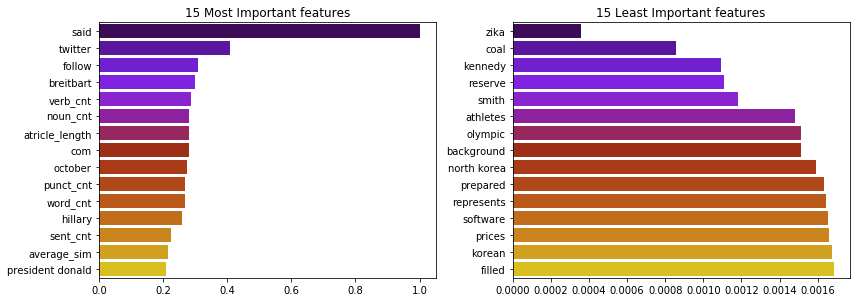

In [92]:
indices = rfc.feature_importances_.argsort()[::-1] 
feature_importance = rfc.feature_importances_/rfc.feature_importances_.max()

plt.figure(figsize=(12,8))
plt.subplot(221)
sns.barplot(x=feature_importance[indices][:15],y = [bow_train_chars.columns[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Most Important features")
plt.subplot(222)
indices = rfc.feature_importances_.argsort() 
sns.barplot(x=feature_importance[indices][:15],y = [bow_train_chars.columns[i] for i in  indices][:15],palette="gnuplot")
plt.title("15 Least Important features")
plt.tight_layout()
plt.show()

The model seems to be generalizing well on the test set too!

## Conlusion

The goal here is to create a model that can generalize to any news article. This is why we used not only the word vector features but also the characteristics of the documents as well in a hope to capture not only what the article is about but how it is written. 

There are some limitations that need to be mentioned here, though. The data set chosen could be more thoughly vetted. It seemed during the topic modeling that the mojority was political. Web scraping and implimenting a contiuous flow of a variety of documents would be more benificial and probably produce better results.  

There is obviously more that can be done here. There are many many more combinations of features and algorithims that we haven't tried that could have possibly perfomed better. Future work could include stacking models, since we have so many different cobinations to choose from and our goal is prediction. I think neural nets could possibly produce some meanigful result as well. 